<a href="https://colab.research.google.com/github/jpedro-rod/ElementosFinitos/blob/main/Elementos_Finitos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Elementos Finitos 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import itertools as it   #biblioteca com funções de permutação a serem usadas na interação da matriz de conectividade com a global

Formulação forte de um problema de condução de calor estacionário em uma placa:

$\nabla\cdot\vec{q} + G = 0 \;,\;\; \vec{q} = -k\nabla T$

Formulação fraca:

$∫_{\Omega}[\nabla\cdot\vec{q} + G]\cdot \omega(x,y) \;\; d\Omega = 0, ∀\omega \in U^0$

$∫_{\Omega}[\nabla\cdot\vec{q}\omega + G\omega] \;\; d\Omega = 0, ∀\omega \in U^0$

Pelo Teorema de Green (funcionando como a regra do produto funcionava em 01 dimensão):

$\oint_{\Gamma}\omega\vec{q}\cdot\vec{n} \; d\Gamma - \int_{Ω} \nabla\omega\cdot\vec{q} \;\; dΩ + \int_{\Omega} G\omega \;\; dΩ= 0 \;\;\;\; (I)$

Reescrevendo a 1ª parcela em função das condições de contorno, ter-se-á:

$\oint_{\Gamma}\omega\vec{q}\cdot\vec{n} \; d\Gamma = \int_{\Gamma_q} \omega\vec{q}\cdot\vec{n} \; d\Gamma_q + \int_{\Gamma_T} \omega\vec{q}\cdot\vec{n} \; d\Gamma_T$

Sabe-se ainda que $\omega(x,y)=0$ em $\Gamma_T$, o que simplifica a equação oriunda do Teorema de Green:

$\oint_{\Gamma}\omega\vec{q}\cdot\vec{n} \; d\Gamma = \int_{\Gamma_q} \omega\vec{q}\cdot\vec{n} \; d\Gamma_q \;\;\;\; (II)$

Inserindo $II$ em $I$ e definindo $\overline{q}=\vec{q}\cdot\vec{n}$ finalmente:

$\int_{Ω} \nabla\omega\cdot\vec{q} \;\; dΩ = \int_{\Gamma_q} \omega\overline{q} \;\; dΓ_q + \int_{\Omega} \omega G \;\; dΩ$

$\int_{Ω} \nabla\omega\cdot(-k\nabla T) \;\; dΩ = \int_{\Gamma_q} \omega\overline{q} \;\; dΓ_q + \int_{\Omega} \omega G \;\; dΩ$

Discretizando a fórmula fraca:

$\int_{Ω} -B^{e^T}\omega^{e^T} \cdot k \cdot B^eT^e dΩ^e = \int_{\Gamma_q} N^{e^T}\omega^{e^T}\overline{q} \;\; dΓ_q^e + \int_{\Omega} N^{e^T}\omega^{e^T}G \;\; dΩ^e$

Onde $N^e$ é *matriz* de funções de interpolação (ou de forma) e $B^e$ é matriz das derivadas de $N^e$

$\int_{Ω} -B^{e^T} k B^e \cdot T^e dΩ^e = \int_{\Gamma_q} N^{e^T}\overline{q} \;\; dΓ_q^e + \int_{\Omega} N^{e^T}G \;\; dΩ^e$

## Funções de forma (ou de interpolação)

In [2]:
#1ª ordem:
#N1 = [N11, N12]

def N11(x):
    return 4-x

def N12(x):
    return x-3

def B11(x):
    return -1

def B12(x):
    return 1

#2ª ordem:
#N2 = [N21, N22, N23]

def N21(x):
    return (2/2**2)*(x-2)*(x-3)

def N22(x):
    return (-4/2**2)*(x-1)*(x-3)

def N23(x):
    return (2/2**2)*(x-1)*(x-2)

# B2 = [B21, B22, B23]

def B21(x):
    return (1/2)*(2*x-5)

def B22(x):
    return -2*x+4

def B23(x):
    return (1/2)*(2*x-3)

## Condução de calor em barra delgada

Condução de calor numa barra fina e homogênea com extremidades a temperaturas fixas e submetida a geração de calor de comportamento linear:

$L = 4\:m = 4 \;,\;\; A = 1\:m^2 \;,\;\; K = 5\:W/(°Cm)$

$G(x) = \frac{50}{3}(x+2) \;,\;\; T(x=1) = 100°C \;,\;\; T(x=4) = 0$

$$\int_{Ω} B^{e^T} k B^e \; dx^e \cdot T^e + \int_{\Omega} N^{e^T}G \;\; dx^e = 0$$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Matriz de conectividade: 
[[0. 1.]
 [1. 2.]
 [2. 3.]
 [3. 4.]
 [4. 5.]
 [5. 6.]]
22.91666666666668
-250.0
0.0
22.91666666666668
0.0
0.0
22.916666666666668
0.0
0.0
22.91666666666667
0.0
0.0
22.916666666666668
0.0
-0.0

Matrizes globais: 
K
[[ 5.  -2.5  0.   0.   0. ]
 [-2.5  5.  -2.5  0.   0. ]
 [ 0.  -2.5  5.  -2.5  0. ]
 [ 0.   0.  -2.5  5.  -2.5]
 [ 0.   0.   0.  -2.5  5. ]]
G
[-227.08333333   22.91666667   22.91666667   22.91666667   22.91666667]

Campo de temperatura (solução numérica): 
[100.          60.41666667  30.           8.75        -3.33333333
  -6.25         0.        ]


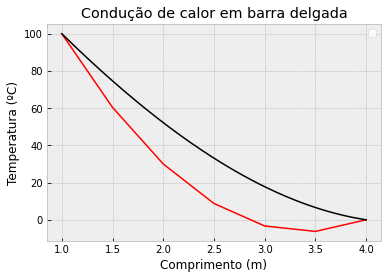

In [6]:
#Parâmetros Físicos

Xo = 1
Xf = 4
A = 1
k = 5
To = 100
Tf = 0

def S(x):
    return (50/3)*(x+2)

#Parâmetros numéricos############################

#OBS.: "ligacoes" se difere de nós pois se refere a pontos que ficam apenas nas fronteiras de cada elemento. "ligacoes" não abrange nós no interior de elementos, como nos de 2ª ordem.

ordemElemento = 1   #1 ou 2

ligacoes = 7                              #PARA 2ª ORDEM SOMENTE NÚMEROS ÍMPARES
malha = np.linspace(Xo,Xf,ligacoes)

#################################################

#Montando matrizes elementares e integrando
##Função de integração a ser usada
def INT(f,Xo,Xf):
    return sp.integrate.quad(f,Xo,Xf)[0]

##Produtos das funções de forma 1ª ordem
if ordemElemento == 1:

    ###Definindo nº de elementos e nós 
    nElementos = len(malha)-1          #O nº de elementos sempre será inteiro independente se nº de ligações é par ou impar
    nNos = nElementos+1
    
    nNosLocais = 2

    K11 = lambda x : B11(x)*k*B11(x)
    K12 = lambda x : B11(x)*k*B12(x)
    K21 = lambda x : B12(x)*k*B11(x)
    K22 = lambda x : B12(x)*k*B12(x)

    G1 = lambda x : S(x)*N11(x)
    G2 = lambda x : S(x)*N12(x)

##Integrando e montando
    listaKe = np.empty((2,2,nElementos))
    listaGe = np.empty((1,2,nElementos))

    for e in range(0,nElementos):
        Ke = np.array([[INT(K11,malha[e],malha[e+1]),INT(K12,malha[e],malha[e+1])],
                    [INT(K21,malha[e],malha[e+1]),INT(K22,malha[e],malha[e+1])]])         

        Ge = np.array([[INT(G1,malha[e],malha[e+1]),INT(G2,malha[e],malha[e+1])]])

        listaKe[:,:,e] = Ke
        listaGe[:,:,e] = Ge


##Produtos das funções de forma 2ª ordem
elif ordemElemento == 2:
    
    ###Definindo nº de elementos e nós
    nElementos = (len(malha)-1)/2          #O nº de elementos será inteiro quando nº de ligações for ímpar e racional quando nº de ligações for par
    nNos = int(3*nElementos - (nElementos-1))

    nNosLocais = 3
    
    nElementos = int(nElementos)     #Para ser possível realizar os loops mais abaixo e montar a lista de matrizes de elementos

    K11 = lambda x : B21(x)*k*B21(x)
    K12 = lambda x : B21(x)*k*B22(x)
    K13 = lambda x : B21(x)*k*B23(x)
    K21 = lambda x : B22(x)*k*B21(x)
    K22 = lambda x : B22(x)*k*B22(x)
    K23 = lambda x : B22(x)*k*B23(x)
    K31 = lambda x : B23(x)*k*B21(x)
    K32 = lambda x : B23(x)*k*B22(x)
    K33 = lambda x : B23(x)*k*B23(x)

    G1 = lambda x : S(x)*N21(x)
    G2 = lambda x : S(x)*N22(x)
    G3 = lambda x : S(x)*N23(x)

##Integrando e montando
    listaKe = np.empty((3,3,nElementos))
    listaGe = np.empty((1,3,nElementos))

    '''Há um if dentro do loop porque elementos de 2ª ordem podem terminar incompletos dependendo de como discretizarmos o domínio. Dessa forma é 
    necessário definir uma integração particular para o último elemento em que o integramos só até a metade'''
    
    indice_elemento = 0
    for e in range(0,nNos-1,2):
        
        Ke = np.array([[INT(K11,malha[e],malha[e+2]),INT(K12,malha[e],malha[e+2]),INT(K13,malha[e],malha[e+2])],
                    [INT(K21,malha[e],malha[e+2]),INT(K22,malha[e],malha[e+2]),INT(K23,malha[e],malha[e+2])],
                    [INT(K31,malha[e],malha[e+2]),INT(K32,malha[e],malha[e+2]),INT(K33,malha[e],malha[e+2])]])
            
        Ge = np.array([[INT(G1,malha[e],malha[e+2]),INT(G2,malha[e],malha[e+2]),INT(G3,malha[e],malha[e+2])]])

        listaKe[:,:,indice_elemento] = Ke
        listaGe[:,:,indice_elemento] = Ge
        indice_elemento = indice_elemento + 1

#Matriz de conectividade

M = np.zeros((nElementos,nNosLocais))

##1ª ORDEM
if ordemElemento == 1:
        
    for elemento in range(nElementos):
        for noLocal in range(nNosLocais):
                
            M[elemento,noLocal] = elemento*(nNosLocais - 1) + noLocal

##2ª ORDEM
elif ordemElemento == 2:
    for elemento in range(nElementos):

        for noLocal in range(nNosLocais):

            M[elemento,noLocal] = elemento*(nNosLocais - 1) + noLocal

print("Matriz de conectividade: ")
print(M)

#Matrizes globais

Ks = np.zeros((nNos,nNos))    #Ks pois se refere a matriz global ainda em seu estado singular
Gs= np.zeros(nNos)

nMatrizesElementares = len(listaKe[0,0,:])

##1ª ORDEM
if ordemElemento == 1:

    ###Adicionando cada matriz elementar à matriz global
    for K_elementar_index in range(nMatrizesElementares):

        Kaux = np.zeros((nNos,nNos))

        ##Permutação da matriz global
        posicoes = list(it.product(M[K_elementar_index], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes = [(int(x), int(y)) for x,y in posicoes]             #O método retorna tuplas de floats, apenas passei os dados para int
                
        ##Permutação da matriz elementar
        posicoes_locais = list(it.product([0,1], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes_locais = [(int(x), int(y)) for x,y in posicoes_locais]
                
        #print(posicoes)
        #print(posicoes_locais)
        for i in range(len(posicoes)):
            posicao_global = posicoes[i] 
            posicao_local = posicoes_locais[i] + (K_elementar_index,)
            Kaux[posicao_global] = listaKe[posicao_local]
        #print(Kaux)
        Ks = Ks + Kaux
        
    ###Adicionando cada matriz elementar Ge à matriz global G
    for G_elementar_index in range(nMatrizesElementares):
        
        Gaux = np.zeros(nNos)

        for i in range(2):
            Gaux[G_elementar_index*(nNosLocais - 1) + i] = listaGe[:,i,G_elementar_index]
        #print(Gaux)
        Gs = Gs + Gaux
    '''
    print("\nMatrizes globais singulares: ")   
    print("Ks")  
    print(Ks)
    print("Gs")
    print(Gs)
    '''
##2ª ORDEM
elif ordemElemento == 2:

    ###Adicionando cada matriz elementar Ke à matriz global K
    for K_elementar_index in range(nMatrizesElementares):
        
        Kaux = np.zeros((nNos,nNos))

        ##Permutação da matriz global
        posicoes = list(it.product(M[K_elementar_index], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes = [(int(x), int(y)) for x,y in posicoes]             #O método retorna tuplas de floats, apenas passei os dados para int
        
        ##Permutação da matriz elementar
        posicoes_locais = list(it.product([0,1,2], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes_locais = [(int(x), int(y)) for x,y in posicoes_locais]
        
        #print(posicoes)
        #print(posicoes_locais)
        for i in range(len(posicoes)):
            posicao_global = posicoes[i]
            posicao_local = posicoes_locais[i] + (K_elementar_index,)
            Kaux[posicao_global] = listaKe[posicao_local]
        #print(Kaux)
        Ks = Ks + Kaux
        
    ###Adicionando cada matriz elementar Ge à matriz global G
    for G_elementar_index in range(nMatrizesElementares):
        
        Gaux = np.zeros(nNos)

        if ligacoes%2 == 0 and G_elementar_index == ultimoGe:

            for i in range(2):
                Gaux[G_elementar_index*(nNosLocais - 1) + i] = listaGe[:,i,G_elementar_index]

            Gs = Gs + Gaux
        
        else:
            for i in range(3):
                Gaux[G_elementar_index*(nNosLocais - 1) + i] = listaGe[:,i,G_elementar_index]
   
            Gs = Gs + Gaux
    '''
    print("\nMatrizes globais singulares: ")
    print("Ks")  
    print(Ks)
    print("Gs")
    print(Gs)
    '''
#Aplicação das condições de contorno na matriz e vetor independente:   K.T + G = 0

##K
###1º contorno
K = np.delete(Ks,obj=0,axis=0)   #eliminando linha
K = np.delete(K,obj=0, axis=1)   #eliminando coluna
###2º contorno
K = np.delete(K,obj=-1, axis=0)    #eliminando linha
K = np.delete(K,obj=-1, axis=1)   #eliminando coluna

##G
G = Gs[1:-1]

KLinhaEliminada = np.delete(Ks,obj=0,axis=0)
KLinhaEliminada = np.delete(KLinhaEliminada,obj=-1,axis=0)

for i in range(len(G)):
    
    G[i] = G[i] + To*KLinhaEliminada[i,0] + Tf*KLinhaEliminada[i,-1]

print("\nMatrizes globais: ")
print("K") 
print(K)
print("G")
print(G)

#Solucionando o sistema

CampoTSemContorno = np.linalg.solve(K,-G)

BCo = np.array([To])
BCf = np.array([Tf])
CampoTemperatura = np.concatenate((BCo,CampoTSemContorno,BCf))

print("\nCampo de temperatura (solução numérica): ")  
print(CampoTemperatura)

#Solução analítica

DominioAnalitico = np.linspace(Xo,Xf,200)

def CampoTAnalitico(x):
    return (5/9)*x**3 + (10/3)*x**2 - (185/3)*x + 1420/9

#Exibindo as soluções

plt.style.use('bmh')

fig, (ax1) = plt.subplots(1, 1, sharey=True, sharex = True)
    
ax1.plot(malha, CampoTemperatura, color='red', linewidth=1.5)
ax1.plot(DominioAnalitico, CampoTAnalitico(DominioAnalitico), color='black', linewidth=1.5)
ax1.set_title('Condução de calor em barra delgada')
ax1.set_xlabel('Comprimento (m)')
ax1.set_ylabel('Temperatura (ºC)')
ax1.legend(loc='best',facecolor ='w')



## Rascunho

In [4]:
'''
#Parâmetros numéricos############################

ligacoes = 4
malha = np.linspace(Xo,Xf,ligacoes)

#OBS.: "ligacoes" se difere de nós pois se refere a pontos que ficam apenas nas fronteiras de cada elemento. "ligacoes" não abrange nós no interior de elementos, como nos de 2ª ordem.

ordemElemento = 2   #1 ou 2

#################################################

#Montando matrizes elementares e integrando
##Função de integração a ser usada
def INT(f,Xo,Xf):
    return sp.integrate.quad(f,Xo,Xf)[0]

##Produtos das funções de forma 1ª ordem
if ordemElemento == 1:

    ###Definindo nº de elementos e nós 
    nElementos = len(malha)-1          #O nº de elementos sempre será inteiro independente se nº de ligações é par ou impar
    nNos = nElementos+1
    
    nNosLocais = 2

    K11 = lambda x : B11(x)*k*B11(x)
    K12 = lambda x : B11(x)*k*B12(x)
    K21 = lambda x : B12(x)*k*B11(x)
    K22 = lambda x : B12(x)*k*B12(x)

    G1 = lambda x : S(x)*N11(x)
    G2 = lambda x : S(x)*N12(x)

##Integrando e montando
    listaKe = np.empty((2,2,nElementos))
    listaGe = np.empty((1,2,nElementos))

    for e in range(0,nElementos):
        Ke = np.array([[INT(K11,malha[e],malha[e+1]),INT(K12,malha[e],malha[e+1])],
                    [INT(K21,malha[e],malha[e+1]),INT(K22,malha[e],malha[e+1])]])         

        Ge = np.array([[INT(G1,malha[e],malha[e+1]),INT(G2,malha[e],malha[e+1])]])
        
        listaKe[:,:,e] = Ke
        listaGe[:,:,e] = Ge

##Produtos das funções de forma 2ª ordem
elif ordemElemento == 2:
    
    ###Definindo nº de elementos e nós
    nElementos = (len(malha)-1)/2          #O nº de elementos será inteiro quando nº de ligações for ímpar e racional quando nº de ligações for par
    nNos = int(3*nElementos - (nElementos-1))

    nNosLocais = 3

    nElementos = int(nElementos + 0.5)     #Para ser possível realizar os loops mais abaixo e montar a lista de matrizes de elementos

    K11 = lambda x : B21(x)*k*B21(x)
    K12 = lambda x : B21(x)*k*B22(x)
    K13 = lambda x : B21(x)*k*B23(x)
    K21 = lambda x : B22(x)*k*B21(x)
    K22 = lambda x : B22(x)*k*B22(x)
    K23 = lambda x : B22(x)*k*B23(x)
    K31 = lambda x : B23(x)*k*B21(x)
    K32 = lambda x : B23(x)*k*B22(x)
    K33 = lambda x : B23(x)*k*B23(x)

    G1 = lambda x : S(x)*N21(x)
    G2 = lambda x : S(x)*N22(x)
    G3 = lambda x : S(x)*N23(x)

##Integrando e montando
    listaKe = np.empty((3,3,nElementos))
    listaGe = np.empty((1,3,nElementos))

    #Há um if dentro do loop porque elementos de 2ª ordem podem terminar incompletos dependendo de como discretizarmos o domínio. Dessa forma é 
    #necessário definir uma integração particular para o último elemento em que o integramos só até a metade
    
    indice_elemento = 0
    for e in range(0,nNos-1,2):

        ultimoNo = list(range(0,nNos-1,2))[-1]
        
        if ligacoes%2 == 0 and e == ultimoNo:
            Ke = np.array([[INT(K11,malha[e],malha[e+1]),INT(K12,malha[e],malha[e+1]),INT(K13,malha[e],malha[e])],
                           [INT(K21,malha[e],malha[e+1]),INT(K22,malha[e],malha[e+1]),INT(K23,malha[e],malha[e])],
                           [INT(K31,malha[e],malha[e]),INT(K32,malha[e],malha[e]),INT(K33,malha[e],malha[e])]])

            Ge = np.array([[INT(G1,malha[e],malha[e+1]),INT(G2,malha[e],malha[e+1]),INT(G3,malha[e],malha[e+1])]])

        else:
            Ke = np.array([[INT(K11,malha[e],malha[e+2]),INT(K12,malha[e],malha[e+2]),INT(K13,malha[e],malha[e+2])],
                           [INT(K21,malha[e],malha[e+2]),INT(K22,malha[e],malha[e+2]),INT(K23,malha[e],malha[e+2])],
                           [INT(K31,malha[e],malha[e+2]),INT(K32,malha[e],malha[e+2]),INT(K33,malha[e],malha[e+2])]])
                
            Ge = np.array([[INT(G1,malha[e],malha[e+2]),INT(G2,malha[e],malha[e+2]),INT(G3,malha[e],malha[e+2])]])

        listaKe[:,:,indice_elemento] = Ke
        listaGe[:,:,indice_elemento] = Ge
        indice_elemento = indice_elemento + 1

#Matriz de conectividade

M = np.zeros((nElementos,nNosLocais))

##1ª ORDEM
if ordemElemento == 1:
        
    for elemento in range(nElementos):
        for noLocal in range(nNosLocais):
                
            M[elemento,noLocal] = elemento*(nNosLocais - 1) + noLocal

##2ª ORDEM
elif ordemElemento == 2:
    for elemento in range(nElementos):

        ultimoElemento = list(range(nElementos))[-1]
        if  ligacoes%2 == 0 and elemento == ultimoElemento:
            for noLocal in range(2):

                M[elemento,noLocal] = elemento*(nNosLocais - 1) + noLocal

        else:
            for noLocal in range(nNosLocais):

                M[elemento,noLocal] = elemento*(nNosLocais - 1) + noLocal

print("Matriz de conectividade: ")
print(M)

#Matrizes globais

Ks = np.zeros((nNos,nNos))    #Ks pois se refere a matriz global ainda em seu estado singular
Gs= np.zeros(nNos)

nMatrizesElementares = len(listaKe[0,0,:])

##1ª ORDEM
if ordemElemento == 1:

    ###Adicionando cada matriz elementar à matriz global
    for K_elementar_index in range(nMatrizesElementares):

        Kaux = np.zeros((nNos,nNos))

        ##Permutação da matriz global
        posicoes = list(it.product(M[K_elementar_index], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes = [(int(x), int(y)) for x,y in posicoes]             #O método retorna tuplas de floats, apenas passei os dados para int
                
        ##Permutação da matriz elementar
        posicoes_locais = list(it.product([0,1], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes_locais = [(int(x), int(y)) for x,y in posicoes_locais]
                
        #print(posicoes)
        #print(posicoes_locais)
        for i in range(len(posicoes)):
            posicao_global = posicoes[i] 
            posicao_local = posicoes_locais[i] + (K_elementar_index,)
            Kaux[posicao_global] = listaKe[posicao_local]
        #print(Kaux)
        Ks = Ks + Kaux
    
    ###Adicionando cada matriz elementar Ge à matriz global G
    for G_elementar_index in range(nMatrizesElementares):
        
        Gaux = np.zeros(nNos)

        for i in range(2):
            Gaux[G_elementar_index*(nNosLocais - 1) + i] = listaGe[:,i,G_elementar_index]

        Gs = Gs + Gaux

    print("\nMatrizes globais singulares: ")   
    print(Ks)
    print(Gs)

##2ª ORDEM
elif ordemElemento == 2:

    ###Adicionando cada matriz elementar Ke à matriz global K
    for K_elementar_index in range(nMatrizesElementares):
        
        Kaux = np.zeros((nNos,nNos))
        ultimoKe = list(range(nMatrizesElementares))[-1]

        if ligacoes%2 == 0 and K_elementar_index == ultimoKe:
            ##Permutação da matriz global
            posicoes = list(it.product(M[K_elementar_index,0:2], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
            posicoes = [(int(x), int(y)) for x,y in posicoes]

            ##Permutação da matriz elementar
            posicoes_locais = list(it.product([0,1], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
            posicoes_locais = [(int(x), int(y)) for x,y in posicoes_locais]
            
            #print(posicoes)
            #print(posicoes_locais)
            for i in range(len(posicoes)):
                posicao_global = posicoes[i]
                posicao_local = posicoes_locais[i] + (K_elementar_index,)
                Kaux[posicao_global] = listaKe[posicao_local]
            #print(Kaux)
            Ks = Ks + Kaux

        else:
            ##Permutação da matriz global
            posicoes = list(it.product(M[K_elementar_index], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
            posicoes = [(int(x), int(y)) for x,y in posicoes]             #O método retorna tuplas de floats, apenas passei os dados para int
            
            ##Permutação da matriz elementar
            posicoes_locais = list(it.product([0,1,2], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
            posicoes_locais = [(int(x), int(y)) for x,y in posicoes_locais]
            
            #print(posicoes)
            #print(posicoes_locais)
            for i in range(len(posicoes)):
                posicao_global = posicoes[i]
                posicao_local = posicoes_locais[i] + (K_elementar_index,)
                Kaux[posicao_global] = listaKe[posicao_local]
            #print(Kaux)
            Ks = Ks + Kaux

    ###Adicionando cada matriz elementar Ge à matriz global G
    for G_elementar_index in range(nMatrizesElementares):
        
        Gaux = np.zeros(nNos)
        ultimoGe = list(range(nMatrizesElementares))[-1]

        if ligacoes%2 == 0 and G_elementar_index == ultimoGe:

            for i in range(2):
                Gaux[G_elementar_index*(nNosLocais - 1) + i] = listaGe[:,i,G_elementar_index]

            Gs = Gs + Gaux
        
        else:
            for i in range(3):
                Gaux[G_elementar_index*(nNosLocais - 1) + i] = listaGe[:,i,G_elementar_index]
   
            Gs = Gs + Gaux

    print("\nMatrizes globais singulares: ")
    print("Ks")  
    print(Ks)
    print("Gs")
    print(Gs)

#Aplicação das condições de contorno na matriz e vetor independente:   K.T + G = 0

##K
###1º contorno
K = np.delete(Ks,obj=0,axis=0)   #eliminando linha
K = np.delete(K,obj=0, axis=1)   #eliminando coluna
###2º contorno
K = np.delete(K,obj=-1, axis=0)    #eliminando linha
K = np.delete(K,obj=-1, axis=1)   #eliminando coluna

##G
G = Gs[1:-1]

KLinhaElimnada = np.delete(Ks,obj=0,axis=0)
KLinhaElimnada = np.delete(KLinhaElimnada,obj=-1,axis=0)

for i in range(len(G)):
    G[i] = G[i] + To*KLinhaElimnada[i,0] + Tf*KLinhaElimnada[i,-1]

print("\nMatrizes globais: ")
print("K") 
print(K)
print("G")
print(G)

#Solucionando o sistema

CampoTSemContorno = np.linalg.solve(K,-G)

BCo = np.array([To])
BCf = np.array([Tf])
CampoTemperatura = np.concatenate((BCo,CampoTSemContorno,BCf))

print("\nCampo de temperatura (solução numérica): ")  
print(CampoTemperatura)

#Solução analítica

DominioAnalitico = np.linspace(Xo,Xf,200)

def CampoTAnalitico(x):
    return (5/9)*x**3 + (10/3)*x**2 - (185/3)*x + 1420/9

#Exibindo as soluções

plt.style.use('bmh')

fig, (ax1) = plt.subplots(1, 1, sharey=True, sharex = True)
    
ax1.plot(malha, CampoTemperatura, color='red', linewidth=1.5)
ax1.plot(DominioAnalitico, CampoTAnalitico(DominioAnalitico), color='black', linewidth=1.5)
ax1.set_title('Condução de calor em barra delgada')
ax1.set_xlabel('Comprimento (m)')
ax1.set_ylabel('Temperatura (ºC)')
ax1.legend(loc='best',facecolor ='w')
'''

'\n#Parâmetros numéricos############################\n\nligacoes = 4\nmalha = np.linspace(Xo,Xf,ligacoes)\n\n#OBS.: "ligacoes" se difere de nós pois se refere a pontos que ficam apenas nas fronteiras de cada elemento. "ligacoes" não abrange nós no interior de elementos, como nos de 2ª ordem.\n\nordemElemento = 2   #1 ou 2\n\n#################################################\n\n#Montando matrizes elementares e integrando\n##Função de integração a ser usada\ndef INT(f,Xo,Xf):\n    return sp.integrate.quad(f,Xo,Xf)[0]\n\n##Produtos das funções de forma 1ª ordem\nif ordemElemento == 1:\n\n    ###Definindo nº de elementos e nós \n    nElementos = len(malha)-1          #O nº de elementos sempre será inteiro independente se nº de ligações é par ou impar\n    nNos = nElementos+1\n    \n    nNosLocais = 2\n\n    K11 = lambda x : B11(x)*k*B11(x)\n    K12 = lambda x : B11(x)*k*B12(x)\n    K21 = lambda x : B12(x)*k*B11(x)\n    K22 = lambda x : B12(x)*k*B12(x)\n\n    G1 = lambda x : S(x)*N11(x)\n  

In [5]:
print(list(range(nMatrizesElementares)))
INT(K31,0,0)
A = np.array([[1,1,1],[1,1,1]])
print(A[3:5,3:5])
a = (1,2,3)
b = (5,)
print(a+b)

[0, 1, 2, 3, 4, 5]


NameError: name 'K31' is not defined

In [ ]:
'''
A = np.array([[1,1,1],[1,1,1]])
B = np.array([[1,1],[2,2],[3,3]])
C = np.array([[1],[2],[3]])
Ct = np.transpose(C)

D = np.array([[1,2,3]])
Dt = np.transpose(D)
print(D.shape)
print(Dt.shape)
print(D)
print(Dt)
print(Dt @ D)

Se = np.array([[S]])

#Vetores de forma

Net = np.array([[N21,N22,N23]])
Ne = np.transpose(Net)

Bet = np.array([[B21,B22,B23]])
Be = np.transpose(Bet)

#Matrizes elementares

dK = Be@Bet   #Certo seria Be @ K @ Bet, mas como em uma dimensão K é escalar, o produto se torna comutativo
dG = Se@Net
'''

'\nA = np.array([[1,1,1],[1,1,1]])\nB = np.array([[1,1],[2,2],[3,3]])\nC = np.array([[1],[2],[3]])\nCt = np.transpose(C)\n\nD = np.array([[1,2,3]])\nDt = np.transpose(D)\nprint(D.shape)\nprint(Dt.shape)\nprint(D)\nprint(Dt)\nprint(Dt @ D)\n\nSe = np.array([[S]])\n\n#Vetores de forma\n\nNet = np.array([[N21,N22,N23]])\nNe = np.transpose(Net)\n\nBet = np.array([[B21,B22,B23]])\nBe = np.transpose(Bet)\n\n#Matrizes elementares\n\ndK = Be@Bet   #Certo seria Be @ K @ Bet, mas como em uma dimensão K é escalar, o produto se torna comutativo\ndG = Se@Net\n'